In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [34]:
df = pd.read_csv('train.csv')

In [35]:
df = df.drop(columns=['Alley', 'MasVnrType', 'FireplaceQu','PoolQC','Fence', 'MiscFeature'])
df = df.dropna()
df = pd.get_dummies(df, drop_first=True)
df = df.astype(int)

In [36]:
df.shape

(1094, 220)

In [38]:
y = df['SalePrice']
X = df.drop('SalePrice', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (875, 219)
X_test : (219, 219)
y_train : (875,)
y_test : (219,)


In [39]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [47]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.layer4(x)
        return x

In [48]:
model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [51]:
print(model)

SimpleNN(
  (layer1): Linear(in_features=219, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [57]:
train_loss = []
def train(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        train_loss.append(epoch_loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

def evaluate(model, test_loader, criterion):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}')

In [58]:
train(model, train_loader, criterion, optimizer, epochs=500)
evaluate(model, test_loader, criterion)

Epoch [10/500], Loss: 1717089766.8571
Epoch [20/500], Loss: 1823907995.4286
Epoch [30/500], Loss: 1676644923.4286
Epoch [40/500], Loss: 1664770507.4286
Epoch [50/500], Loss: 1658699490.2857
Epoch [60/500], Loss: 1535834755.4286
Epoch [70/500], Loss: 1704879653.7143
Epoch [80/500], Loss: 1601411835.4286
Epoch [90/500], Loss: 1535987307.4286
Epoch [100/500], Loss: 1516937973.7143
Epoch [110/500], Loss: 1591257653.7143
Epoch [120/500], Loss: 1698276610.2857
Epoch [130/500], Loss: 1475688653.7143
Epoch [140/500], Loss: 1556821980.0000
Epoch [150/500], Loss: 1478369622.8571
Epoch [160/500], Loss: 1636831629.7143
Epoch [170/500], Loss: 1497587177.1429
Epoch [180/500], Loss: 1570463284.5714
Epoch [190/500], Loss: 1395208358.8571
Epoch [200/500], Loss: 1317841026.2857
Epoch [210/500], Loss: 1398891614.8571
Epoch [220/500], Loss: 1302762918.8571
Epoch [230/500], Loss: 1409445168.0000
Epoch [240/500], Loss: 1291827130.2857
Epoch [250/500], Loss: 1394661304.0000
Epoch [260/500], Loss: 1232938654.

In [64]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2: {r2:.4f}')

MSE: 1256694144.0000
RMSE: 35449.8828
MAE: 22492.1777
R2: 0.8329


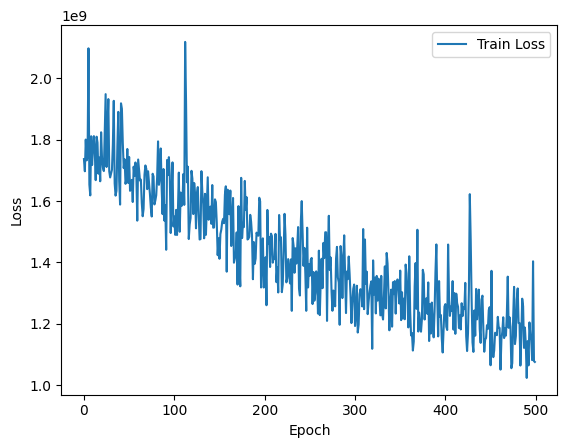

In [65]:
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

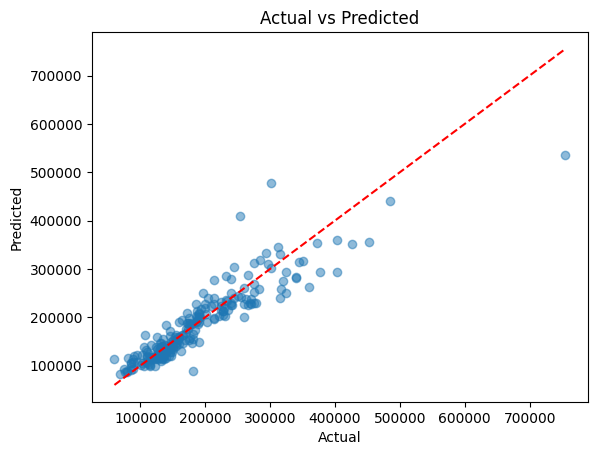

In [61]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()